In [21]:
import xarray as xr
import numpy as np
import pandas as pd

from utils.config import TrackerConfig
from utils import cluster

config = TrackerConfig()

In [2]:
nc_folder = "results/nc/"
input_for_clusters = "test_data.nc"
label_cao_output_dir = config.paths.labeled_nc_folder

anomaly_var = config.dataset.scaled_anomaly_var
latitude_dim_name = config.dataset.latitude_dim_name
area_var =  config.dataset.area_var
label_var = config.dataset.label_var
label_filtered_var = config.dataset.label_filtered_var

STDEV_THRESHOLD = config.algorithm.stdev_threshold
AREA_THRESHOLD = config.algorithm.area_threshold
DISTANCE_THRESHOLD = config.algorithm.distance_threshold_km

lon_res = config.dataset.longitude_spatial_res
lat_res = config.dataset.latitude_spatial_res

In [3]:
nc_folder = config.paths.nc_folder
stdev_file = config.files.stdev_file
anomaly_file = config.files.anomaly_file #"test_data.nc"
masked_anomaly_file = config.files.masked_anomaly_file
scaled_anomaly_var = config.dataset.scaled_anomaly_var
min_stdev_threshold = config.algorithm.min_stdev_threshold

In [4]:
temperature_var = config.algorithm.temperature_var
scaled_anomaly_var = config.dataset.scaled_anomaly_var
min_stdev_threshold = config.algorithm.min_stdev_threshold

ds = xr.open_dataset("results/nc/test_data.nc")
stdev = xr.open_dataset("results/nc/stdev.nc")

da = stdev[temperature_var]
da = da.sel(latitude=slice(70, 20))
mask = da >= min_stdev_threshold
mask = cluster.apply_binary_morph(mask,method='dilation')
mask = cluster.apply_binary_morph(mask,method='fill_holes')

In [5]:
ds[scaled_anomaly_var] = ds[scaled_anomaly_var].where(mask,0)

In [6]:
grid_areas = cluster.area_weights(ds[anomaly_var],latitude_dim_name=latitude_dim_name,lon_res=lon_res,lat_res=lat_res)
ds[area_var] = grid_areas.broadcast_like(ds.isel(time=0))

lon_distance, lat_distance = cluster.calculate_grid_distances(data_array=ds,lon_res=lon_res,lat_res=lat_res)
pixel_distance = np.sqrt(lon_distance * lat_distance)
ds['pixel_distance'] = pixel_distance.broadcast_like(ds.isel(time=0))

In [7]:
def wrapper_for_ufunc(anomaly_block, area_block,distance_block, threshold, area_threshold, distance_threshold, block_id=None):
    results = []
    for i in range(anomaly_block.shape[0]):  
        result = cluster.label_filter_and_merge(anomaly_block[i], area_block, distance_block,threshold, area_threshold,distance_threshold)
        results.append(result)
    return np.stack(results)

In [8]:
# Apply to your data
filtered_labels = xr.apply_ufunc(
    wrapper_for_ufunc,
    ds[anomaly_var], 
    ds[area_var],
    ds['pixel_distance'],
    STDEV_THRESHOLD,
    AREA_THRESHOLD,
    DISTANCE_THRESHOLD,
    input_core_dims=[['latitude', 'longitude'], ['latitude', 'longitude'], ['latitude', 'longitude'], [], [], []],
    output_core_dims=[['latitude', 'longitude']],
    dask='parallelized',
    output_dtypes=[int],
)

In [9]:
# Add processed data to dataset
ds[label_filtered_var] = filtered_labels
ds['has_clusters'] = (ds[label_filtered_var] > 0).any(['latitude', 'longitude'])

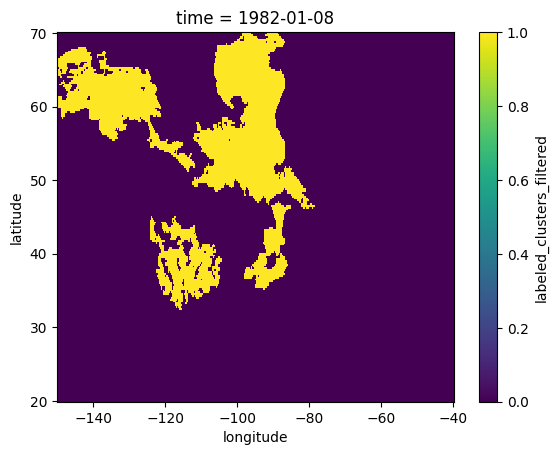

In [10]:
ds["labeled_clusters_filtered"].sel(time='1982-01-08').plot()

In [11]:
from utils import plot_utils
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

[0 1 5]


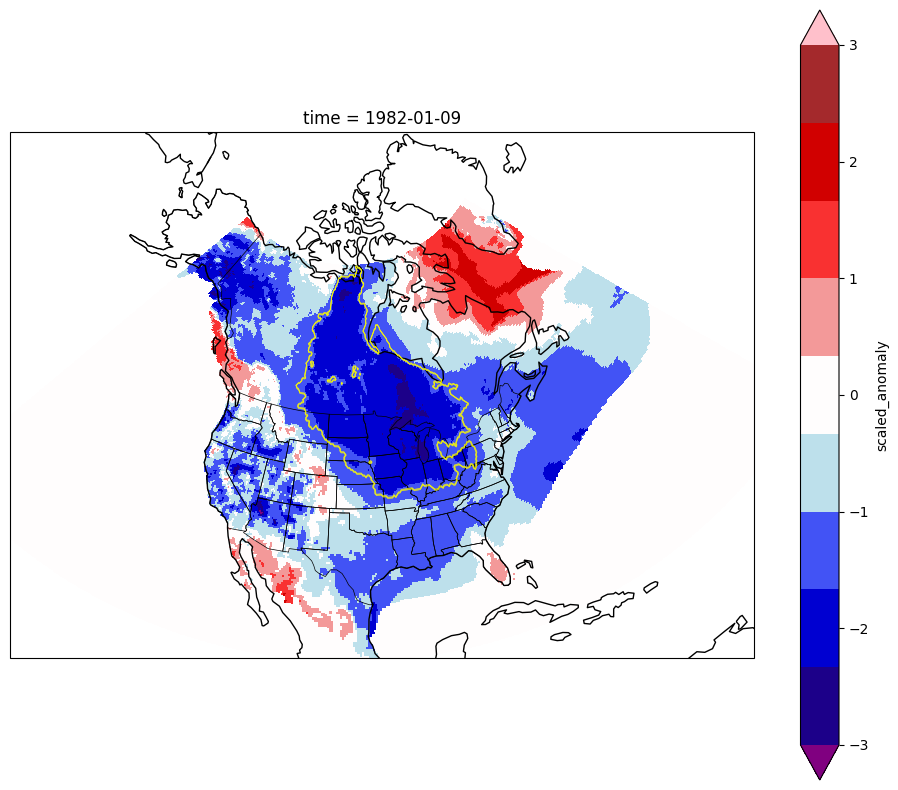

In [12]:
cao_chunk = ds.sel(time = '1982-01-09')
plt.figure(figsize=(12, 10))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
plot_utils.da_plot_zero_centered(cao_chunk['scaled_anomaly'])
cao_chunk['labeled_clusters_filtered'].where(cao_chunk['labeled_clusters_filtered']==1,other=0).plot.contour(transform=ccrs.PlateCarree(),colors='yellow',linewidths=0.3)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())

print(np.unique(cao_chunk['labeled_clusters_filtered']))

In [13]:
var_name = config.dataset.label_filtered_var
labeled_nc_folder = config.paths.labeled_nc_folder
csv_folder = config.paths.csv_folder
cao_cluster_table = config.files.cao_cluster_table
cao_chain_table = config.files.cao_chain_table


def get_cluster_info_for_day(time_idx, ds_ref):
    """Process one day - this will run on dask workers"""
    try:
        day_data = ds_ref.isel(time=time_idx).load()
        return cluster.get_cluster_info(day_data)
    except Exception as e:
        print(f"Error processing day {time_idx}: {e}")
        return pd.DataFrame()  # Return empty DataFrame on error

In [16]:
import joblib
from tqdm import tqdm
from dask.distributed import Client

In [17]:
memory_limit = '5GB'
client = Client(n_workers=12, memory_limit=memory_limit)
print("Running dask at", client.dashboard_link)

Running dask at http://127.0.0.1:8787/status


In [18]:
with joblib.parallel_config(backend="dask"):
    dataframes = joblib.Parallel(verbose=10)(
        joblib.delayed(get_cluster_info_for_day)(i, ds) 
        for i in tqdm(range(len(ds.time)))
    )

 11%|█         | 48/441 [00:02<00:16, 23.40it/s][Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.3s
 22%|██▏       | 96/441 [00:03<00:11, 28.92it/s][Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19093943155976942s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    3.5s
 27%|██▋       | 120/441 [00:03<00:09, 33.14it/s][Parallel(n_jobs=-1)]: Batch computation too fast (0.09684562683105469s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 107 tasks      | elapsed:    4.3s
 38%|███▊      | 168/441 [00:04<00:05, 48.97it/s][Parallel(n_jobs=-1)]: Batch computation too fast (0.04429459571838379s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    4.5s
100%|██████████| 441/4

In [23]:
cluster_info_df = pd.concat([df for df in dataframes if not df.empty], ignore_index=True)
cluster_info_df['time'] = pd.to_datetime(cluster_info_df['time'])

In [24]:
chain_info = cluster.identify_cao_chains(cluster_info_df)

In [25]:
chain_metrics = cluster.calculate_chain_intensity_metrics(chain_info, cluster_info_df)

In [26]:
cluster_with_chains = cluster.add_chain_id_to_clusters(cluster_info_df, chain_info)

In [35]:
ds.time

<xarray.DataArray 'time' (time: 441)> Size: 4kB
array(['1980-02-19T00:00:00.000000000', '1980-02-20T00:00:00.000000000',
       '1980-02-21T00:00:00.000000000', ..., '2000-01-30T00:00:00.000000000',
       '2000-01-31T00:00:00.000000000', '2000-02-01T00:00:00.000000000'],
      shape=(441,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-02-19 1980-02-20 ... 2000-02-01

In [41]:
# Group years into chunks of 10
chunk_size = 10
years = pd.to_datetime(ds.time.values).year
unique_years = np.unique(years)
year_chunks = [unique_years[i:i + chunk_size] for i in range(0, len(unique_years), chunk_size)]
print(f"Writing {len(unique_years)} years in {len(year_chunks)} chunks of {chunk_size}...")
for chunk_idx, year_chunk in enumerate(year_chunks):
    start_year = year_chunk[0]
    end_year = year_chunk[-1]
    print(f"Processing chunk {chunk_idx + 1}/{len(year_chunks)}: {start_year}-{end_year}")
    ds_chunk = ds.sel(time=slice(str(start_year), str(end_year)))
    ds_chunk.to_netcdf(f"temp/nc/labeled_nc/clusters_{start_year}_{end_year}.nc", mode="w")


Writing 21 years in 3 chunks of 10...
Processing chunk 1/3: 1980-1989
Processing chunk 2/3: 1990-1999
Processing chunk 3/3: 2000-2000


In [42]:
def process_in_chunks(ds, label_cao_output_dir,chunk_size_years=10):
    years = pd.to_datetime(ds.time.values).year
    unique_years = np.unique(years)
    
    for i in range(0, len(unique_years), chunk_size_years):
        year_chunk = unique_years[i:i + chunk_size_years]
        start_year, end_year = year_chunk[0], year_chunk[-1]
        
        print(f"Processing years {start_year}-{end_year}...")
        ds_chunk = ds.sel(time=slice(str(start_year), str(end_year)))
        
        # Your processing logic here
        # ... apply clustering, filtering, etc.
        
        # Save results
        ds_chunk.to_netcdf(f"{label_cao_output_dir}/clusters_{start_year}_{end_year}.nc", mode="w")
        
        # Optional: explicitly free memory
        del ds_chunk

In [44]:
process_in_chunks(ds,label_cao_output_dir="temp/nc/labeled_nc/",chunk_size_years=5)

Processing years 1980-1984...
Processing years 1985-1989...
Processing years 1990-1994...
Processing years 1995-1999...
Processing years 2000-2000...
